In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

import sys
# sys.path = ['/home/jxm3/research/retrieval/inversion'] + sys.path
sys.path = [
    p for p in sys.path
    if p not in ['/home/jxm3/research/prompting/imodelsX', '/home/jxm3/research/prompting/tree-prompt']
]
sys.path.append('/home/jxm3/research/retrieval/inversion')

## debugging

we trained our first self-correcting model that's decoder-based. generation from it doesn't seem to be working properly, so going to debug in this notebook.

In [3]:
# model info:
#    https://wandb.ai/jack-morris/emb-correct-1/runs/e9430bc73cfd6fb433eb0e5401d4a7ff
#             path: saves/47d9c149a8e827d0609abbeefdfd89ac

import analyze_utils

checkpoint_folder = '/home/jxm3/research/retrieval/inversion/saves/47d9c149a8e827d0609abbeefdfd89ac'
trainer = analyze_utils.load_trainer(checkpoint_folder)

Loading trainer for analysis – setting --do_eval=1
loading alias dpr_nq__msl32_beta from /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea...
Set train_args.dataloader_num_workers = 4


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was slurred the togy, Was gilber and brittle, Did twave sliths
================ End trainer sanity check ================
Froze 342572160 params from model type <class 'models.inversion.InversionModel'>


[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was the gillig swave and toy, Did bribe slur the wyres, Bel
================ End trainer sanity check ================


In [4]:
trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"]
)

[pred] to the character of the skull of the sutures, which are relatively smooth and untortuous of infant skulls. In fact, like those
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win a Winter Olympic gold medal, and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, while 15% agreed that they should be protected from discrimination. Among gay and straight workers, 63% disagreed and
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H


{'eval_loss': 0.6762245893478394,
 'eval_token_set_precision': 0.7868841329671202,
 'eval_token_set_recall': 0.7894241524458314,
 'eval_token_set_f1': 0.7872981165457503,
 'eval_bleu_score': 45.89207392770204,
 'eval_meteor_score': 0.715975790685012,
 'eval_rouge_score': 0.7610256514449997,
 'eval_bert_score': 0.9380280026197434,
 'eval_emb_cos_sim': 0.9498069286346436,
 'eval_runtime': 12.6388,
 'eval_samples_per_second': 39.561,
 'eval_steps_per_second': 0.158}

In [5]:
trainer.num_gen_recursive_steps = 1
trainer.sanity_decode()

================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was the gilly sliths and bribe, Did towl the snare and waving tyre
================ End trainer sanity check ================


In [14]:
trainer.num_gen_recursive_steps = 20
trainer.sanity_decode()

================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> Was the slithy tollies, And gibe did brimble and gibe, And wave
================ End trainer sanity check ================


In [7]:
from models import CorrectorEncoderModel
isinstance(trainer.model, CorrectorEncoderModel)

True

In [9]:
from tqdm import trange

all_metrics = []

for R in trange(1, 20):
    trainer.gen_kwargs = {
        "early_stopping": False,
        "num_beams": 1,
        "do_sample": False,
        "no_repeat_ngram_size": 0,
    }
    trainer.args.per_device_eval_batch_size = 128
    trainer.num_gen_recursive_steps = R

    metrics = trainer.evaluate(
        eval_dataset=trainer.eval_dataset["nq"]
    )
    metrics['num_rounds'] = R
    all_metrics.append( metrics )

  5%|█████▋                                                                                                     | 1/19 [00:09<02:45,  9.19s/it]

[pred] to the character of the skull of the sutures, which are relatively smooth and untortuous of infant skulls. In fact, like those
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere to win a Winter Olympic gold medal, and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, while 15% agreed that they should be protected from discrimination. Among gay and straight workers, 63% disagreed and
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 11%|███████████▎                                                                                               | 2/19 [00:20<02:52, 10.16s/it]

[pred] to the character of the sutures of the skull, which are relatively smooth and untortuous of an infant skull. In fact, like any
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as other people, including straight, while 15% agreed that they should be protected from discrimination. Workplaces disagreed, 63% H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 16%|████████████████▉                                                                                          | 3/19 [00:33<03:03, 11.49s/it]

[pred] to that of the character of the sutures of the skull, which are relatively smooth and untortuous. In fact, like the infant skull
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed that they should be protected from discrimination. Other workplaces disagreed. 3%, including h
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 21%|██████████████████████▌                                                                                    | 4/19 [00:48<03:14, 12.98s/it]

[pred] to the character of the sutures of the skull, which, in fact, are relatively smooth and untortuous. Like infant skulls,
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed they should be protected from discrimination. Additionally, 69% disagreed. Workplaces with h
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 26%|████████████████████████████▏                                                                              | 5/19 [01:05<03:23, 14.54s/it]

[pred] to that of the character of the sutures of the skull, which, in fact, are relatively smooth and untortuous. Like the infant
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed they should be protected from discrimination. Additionally, 33% disagreed with this. Workplace h
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 32%|█████████████████████████████████▊                                                                         | 6/19 [01:24<03:27, 15.97s/it]

[pred] to the character of the sutures of the skull, which, in fact, are relatively smooth and untortuous like those of infant skull.
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% agreed they should be protected from discrimination. Additionally, 3% disagreed with this: Workplace H and
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 37%|███████████████████████████████████████▍                                                                   | 7/19 [01:45<03:30, 17.58s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 16% agreed they should be protected from workplace discrimination. Among other 15% H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 42%|█████████████████████████████████████████████                                                              | 8/19 [02:08<03:33, 19.39s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. 33% agreed that they should be protected from workplace discrimination. Additionally, 96% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 47%|██████████████████████████████████████████████████▋                                                        | 9/19 [02:32<03:29, 20.92s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 39% agreed they should be protected from workplace discrimination. 63% of H'
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 53%|███████████████████████████████████████████████████████▊                                                  | 10/19 [02:59<03:25, 22.79s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 93% agreed that they should be protected from workplace discrimination. 11% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 58%|█████████████████████████████████████████████████████████████▎                                            | 11/19 [03:28<03:15, 24.47s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 39% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 63%|██████████████████████████████████████████████████████████████████▉                                       | 12/19 [03:59<03:04, 26.43s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 68%|████████████████████████████████████████████████████████████████████████▌                                 | 13/19 [04:31<02:49, 28.25s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 74%|██████████████████████████████████████████████████████████████████████████████                            | 14/19 [05:05<02:30, 30.02s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 15/19 [05:42<02:08, 32.10s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 16/19 [06:20<01:41, 34.00s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 17/19 [07:01<01:12, 36.07s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18/19 [07:44<00:38, 38.07s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [08:29<00:00, 26.81s/it]

[pred] to the character of the sutures of the skull, which, like those of the infant skull, are relatively smooth and untortuous. In
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact



[pred] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'
[true] individual from the Southern Hemisphere, to win a Winter Olympic gold medal and was also part of the short track relay team that won Australia'



[pred] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H
[true] the same rights as straight people, while 15% disagreed. Additionally, 69% agreed that they should be protected from workplace discrimination. 13% of H


In [10]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(all_metrics)
df.head()

,eval_loss,eval_token_set_precision,eval_token_set_recall,eval_token_set_f1,eval_bleu_score,eval_meteor_score,eval_rouge_score,eval_bert_score,eval_emb_cos_sim,eval_runtime,eval_samples_per_second,eval_steps_per_second,num_rounds
0,0.676225,0.787206,0.801009,0.793409,48.597736,0.726691,0.770367,0.941142,0.953380,9.1905,54.404,0.435,1
1,0.676225,0.842962,0.855187,0.848535,58.166789,0.796306,0.830309,0.953395,0.962919,10.8411,46.121,0.369,2
2,0.676225,0.867732,0.878759,0.872764,63.835974,0.828833,0.856032,0.960708,0.970515,13.0629,38.276,0.306,3
3,0.676225,0.887651,0.897446,0.892094,67.767792,0.853166,0.881043,0.965027,0.973964,15.2744,32.735,0.262,4
4,0.676225,0.904891,0.912268,0.908215,71.093460,0.872434,0.895756,0.968542,0.976743,17.2942,28.911,0.231,5


<Axes: xlabel='num_rounds'>

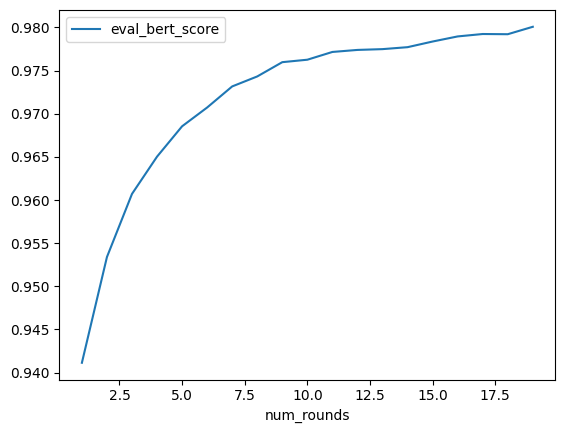

In [15]:
df.plot(x="num_rounds", y="eval_bert_score")

<Axes: xlabel='num_rounds'>

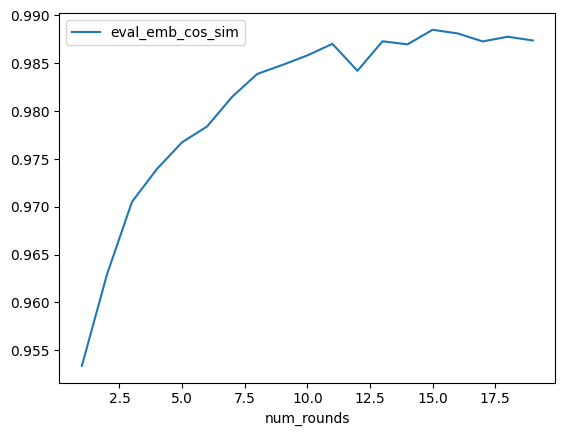

In [12]:
df.plot(x="num_rounds", y="eval_emb_cos_sim")

<Axes: xlabel='num_rounds'>

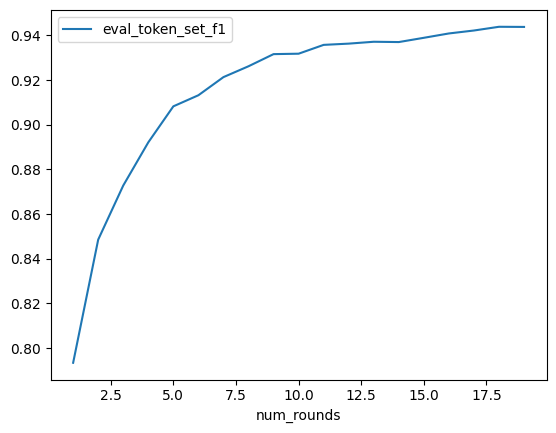

In [13]:
df.plot(x="num_rounds", y="eval_token_set_f1")